In [64]:
import pandas as pd
import numpy as np
import datetime
from IPython import display
from dateutil.parser import parse
from rl4pm_lib.utils_supervised import make_window_features
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
test_df = pd.read_csv('datasets/test_df.csv')
test_df['timestamp'] = test_df['timestamp'].apply(lambda x: parse(x))

train_df = pd.read_csv('datasets/train_df.csv')
train_df['timestamp'] = train_df['timestamp'].apply(lambda x: parse(x))

## Proprocessing:
### 1. Make features
For leveraging predictive models the following features are created:
- $t_e$ - time since previous event
- $t_w$ - time since the beginning of week
- $t_t$ - time since the beginning of trace
- one hot encoded labels

### 2. Make window with lags

### 3. Scale it

In [3]:
import rl4pm_lib.preprocessing as preprocessing
# make features
column_feature = {'tt': 0, 'te': 1, 'tw': 2}
# prepro = preprocessing.DfPreprocesser()
# prepro.fit(train_df)
# train_df_pr = prepro.transform(train_df)
# test_df_pr = prepro.transform(test_df)

In [ ]:
# test_df_pr

In [5]:
win_len = 2

# test_df_pr_win, test_labels, test_tes = make_window_features(train_df_pr, win_len)

# train_df_pr_win, train_labels, train_tes = make_window_features(train_df_pr, win_len)

The data above can be just writed to disk so it is fixed

In [ ]:
# to_write_win_test = test_df_pr_win
# to_write_win_test['labels'] = test_labels
# to_write_win_test['te_true'] = test_tes

# to_write_win_train = train_df_pr_win
# to_write_win_train['labels'] = train_labels
# to_write_win_train['te_true'] = train_tes

# to_write_win_test.to_csv(f'datasets/test_features_win_{win_len}.csv', index=False)
# to_write_win_train.to_csv(f'datasets/train_features_win_{win_len}.csv', index=False)

In [17]:
test_df_pr_win = pd.read_csv(f'datasets/test_features_win_{win_len}.csv')
train_df_pr_win = pd.read_csv(f'datasets/train_features_win_{win_len}.csv')

if 'timestamp' in test_df_pr_win:
    test_df_pr_win['timestamp'] = test_df_pr_win['timestamp'].apply(lambda x: parse(x))
if 'timestamp' in train_df_pr_win:
    train_df_pr_win['timestamp'] = train_df_pr_win['timestamp'].apply(lambda x: parse(x))
    
test_df_pr_win.sort_values(by=['timestamp'], inplace=True)
train_df_pr_win.sort_values(by=['timestamp'], inplace=True)

test_labels, test_tes = test_df_pr_win['labels'], test_df_pr_win['te_true']
test_df_pr_win = test_df_pr_win.drop(columns=['labels', 'te_true'])

train_labels, train_tes = train_df_pr_win['labels'], train_df_pr_win['te_true']
train_df_pr_win = train_df_pr_win.drop(columns=['labels', 'te_true'])

In [61]:
activities = []
_d = train_df_pr_win.copy()
for _c in _d.columns:
    if (_c[:2] == 'W_') and ('__' not in _c):
        activities.append(_c)
activities

['W_Afhandelen leads',
 'W_Beoordelen fraude',
 'W_Completeren aanvraag',
 'W_Nabellen incomplete dossiers',
 'W_Nabellen offertes',
 'W_Valideren aanvraag']

In [18]:
if ('timestamp' in train_df_pr_win) and (type(train_df_pr_win['timestamp'].values[0])==str):
    train_df_pr_win['timestamp'] = train_df_pr_win['timestamp'].apply(lambda x: parse(x))
if ('timestamp' in test_df_pr_win) and (type(test_df_pr_win['timestamp'].values[0])==str):
    test_df_pr_win['timestamp'] = test_df_pr_win['timestamp'].apply(lambda x: parse(x))

Also must scale continious (time related features)

In [19]:
train_df_pr_win.shape, train_labels.shape

((43574, 20), (43574,))

In [20]:
from rl4pm_lib.preprocessing import PaperScalerPd as PaperScaler

Let's construct features as moving window

Ok, features and targets are ready, let's do `.fit()`, `.predict())))))`

What methods will I use? Of course all, which were listed [here](https://github.com/lemikhovalex/DA_CV)

## PipeLine

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', PaperScaler(column_feature)),
                 ('rfc', RandomForestClassifier(n_estimators=30, max_depth=4, random_state=42, n_jobs=-1))
                ])

In [22]:
pipe.fit(train_df_pr_win.drop(columns=['timestamp']), train_labels)

Pipeline(steps=[('scaler',
                 <rl4pm_lib.preprocessing.PaperScalerPd object at 0x000002A54D8A0940>),
                ('rfc',
                 RandomForestClassifier(max_depth=4, n_estimators=30, n_jobs=-1,
                                        random_state=42))])

# Classification
## Random Forest Classifier

In [23]:
from sklearn.model_selection import TimeSeriesSplit
splitter = TimeSeriesSplit(n_splits=7)
xs = splitter.split(train_df_pr_win, train_labels)

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [25]:
%%time
pipe = Pipeline([('scaler', PaperScaler(column_feature)),
                 ('rfc', RandomForestClassifier(n_estimators=30, max_depth=4, random_state=42, n_jobs=-1))
                ])

pipe.fit(train_df_pr_win, train_labels)
train_labels_hat = pipe.predict(train_df_pr_win)
test_labels_hat = pipe.predict(test_df_pr_win)

test_acc_rfc = accuracy_score(test_labels_hat, test_labels)
train_acc_rfc = accuracy_score(train_labels_hat, train_labels)
print(f'Random Forest Classifier\ntest  accuracy = {test_acc_rfc: .2f}\ntrain accuracy = {train_acc_rfc: .2f}')

Random Forest Classifier
test  accuracy =  0.79
train accuracy =  0.79
Wall time: 4.39 s


In [26]:
from sklearn.model_selection import GridSearchCV

In [31]:
%%time
param_grid = { 
    'rfc__n_estimators': np.linspace(140, 250, num=15, dtype=int),
    'rfc__max_depth' : np.linspace(10, 20, num=10, dtype=int),
}

model_gs = Pipeline([('scaler', PaperScaler(column_feature)),
                            ('rfc', RandomForestClassifier(random_state=42))
                           ])
CV_rfc = GridSearchCV(estimator=model_gs, param_grid=param_grid, scoring='accuracy',
                      cv=TimeSeriesSplit(n_splits=5), n_jobs=10, verbose=1)
CV_rfc.fit(train_df_pr_win, train_labels)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   31.7s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:  2.8min
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:  6.9min
[Parallel(n_jobs=10)]: Done 750 out of 750 | elapsed: 13.0min finished


Wall time: 13min 21s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=Pipeline(steps=[('scaler',
                                        <rl4pm_lib.preprocessing.PaperScalerPd object at 0x000002A54D268D90>),
                                       ('rfc',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=10,
             param_grid={'rfc__max_depth': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 20]),
                         'rfc__n_estimators': array([140, 147, 155, 163, 171, 179, 187, 195, 202, 210, 218, 226, 234,
       242, 250])},
             scoring='accuracy', verbose=1)

In [32]:
CV_rfc.best_params_

{'rfc__max_depth': 18, 'rfc__n_estimators': 218}

In [76]:
%%time
rfc_activ_best = CV_rfc.best_estimator_
rfc_activ_best.fit(train_df_pr_win, train_labels)

train_labels_hat = rfc_activ_best.predict(train_df_pr_win)
test_labels_hat = rfc_activ_best.predict(test_df_pr_win)

test_acc_rfc = accuracy_score(test_labels_hat, test_labels)
train_acc_rfc = accuracy_score(train_labels_hat, train_labels)

print(f'Random Forest Classifier, after grid search')
print(f'test  accuracy = {test_acc_rfc: .2f}\ntrain accuracy = {train_acc_rfc: .2f}')

Random Forest Classifier, after grid search
test  accuracy =  0.94
train accuracy =  0.94
Wall time: 19 s


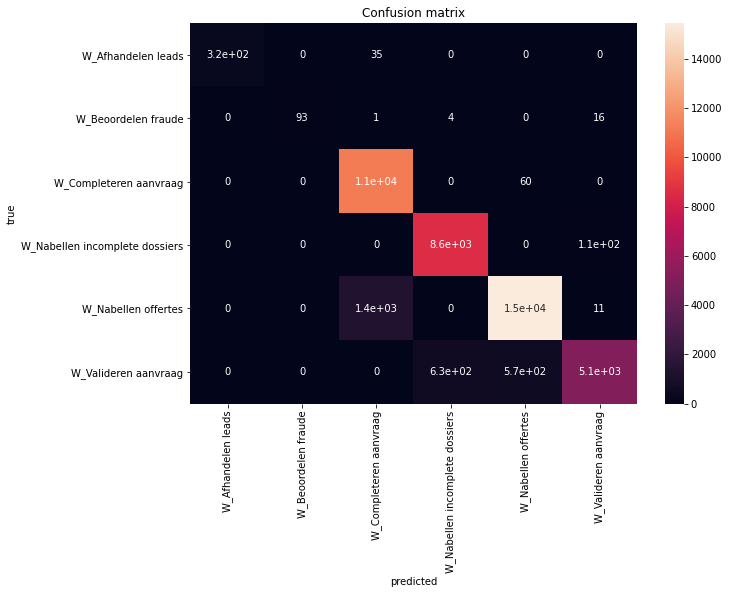

In [77]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, test_labels_hat)
cm_prob = cm / np.nan_to_num(cm, 0).sum(axis=1).reshape(-1, 1)

df_cm = pd.DataFrame(cm, index = activities,
                         columns = activities)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion matrix')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

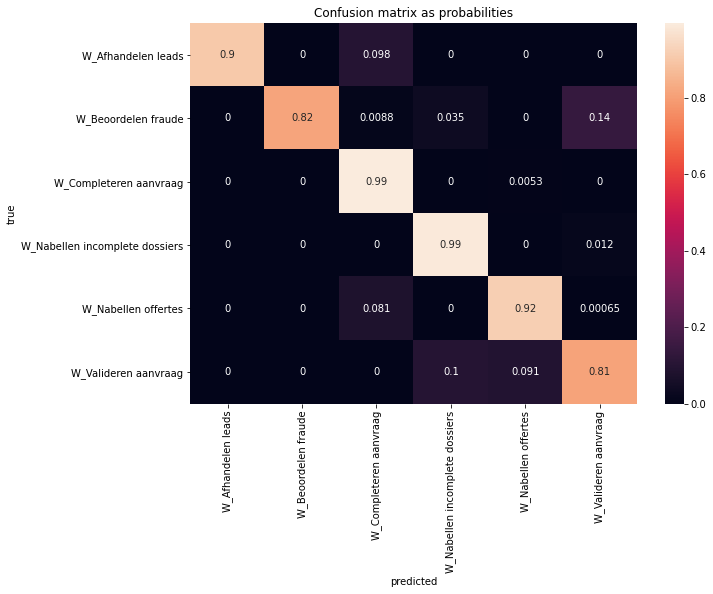

In [78]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, test_labels_hat)
cm_prob = cm / np.nan_to_num(cm, 0).sum(axis=1).reshape(-1, 1)

df_cm = pd.DataFrame(cm_prob, index = activities,
                         columns = activities)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion matrix as probabilities')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

In [39]:
test_labels_hat

array([4, 4, 2, ..., 3, 3, 4], dtype=int64)

Resuls some how are beter then in article on LSTM approach

## K Neighbors Classifier

In [36]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

In [37]:
%%time
grid_knn = { 
    'knn__n_neighbors': np.linspace(3, 30, 6, dtype=int),
    'knn__weights' : ['distance', 'uniform'],
}

model_gs_knn = Pipeline([('scaler', PaperScaler(column_feature)),
                         ('knn', KNeighborsClassifier())
                        ])
CV_knn = GridSearchCV(estimator=model_gs_knn, param_grid=grid_knn, scoring='accuracy',
                      cv=TimeSeriesSplit(n_splits=5), n_jobs=10, verbose=1)
CV_knn.fit(train_df_pr_win, train_labels)

print(CV_knn.best_score_)
print(CV_knn.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   18.8s
[Parallel(n_jobs=10)]: Done  60 out of  60 | elapsed:   32.4s finished


0.7972183971357752
{'knn__n_neighbors': 24, 'knn__weights': 'distance'}
Wall time: 37.1 s


Ok, next

## Grad Boost

In [41]:
import xgboost as xgb

In [45]:
%%time
param = {'objective': 'multi:softprob',  # error evaluation for multiclass training
         'num_class': 6,
         'tree_method': 'gpu_hist',

        }

grid_xgb = {'xgb__max_depth': np.linspace(5, 10, num=5, dtype=int),
            'xgb__n_estimators': np.linspace(3, 10, num=7, dtype=int),
            'xgb__eta': np.linspace(0.001, 0.3, num=20, dtype=float)
           }

model_gs_xgb = Pipeline([('scaler', PaperScaler(column_feature)),
                         ('xgb', xgb.XGBClassifier(**param))
                        ])
CV_xgb = GridSearchCV(estimator=model_gs_xgb, param_grid=grid_xgb, scoring='accuracy',
                      cv=TimeSeriesSplit(n_splits=5), n_jobs=6, verbose=1)
CV_xgb.fit(train_df_pr_win, train_labels)

print(CV_xgb.best_score_)
print(CV_xgb.best_params_)

Fitting 5 folds for each of 700 candidates, totalling 3500 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   23.2s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  7.2min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed: 11.3min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed: 16.2min
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed: 22.0min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed: 28.7min
[Parallel(n_jobs=6)]: Done 3500 out of 3500 | elapsed: 31.6min finished


0.8134398237400167
{'xgb__eta': 0.28426315789473683, 'xgb__max_depth': 8, 'xgb__n_estimators': 10}
Wall time: 31min 38s


In [48]:
xgb_clf_best = CV_xgb.best_estimator_

In [79]:
train_labels_hat = xgb_clf_best.predict(train_df_pr_win)
test_labels_hat = xgb_clf_best.predict(test_df_pr_win)

test_acc_xgb = accuracy_score(test_labels_hat, test_labels)
train_acc_xgb = accuracy_score(train_labels_hat, train_labels)

print(f'XG boost Classifier')
print(f'test  accuracy = {test_acc_xgb: .2f}\ntrain accuracy = {train_acc_xgb: .2f}')

XG boost Classifier
test  accuracy =  0.84
train accuracy =  0.84


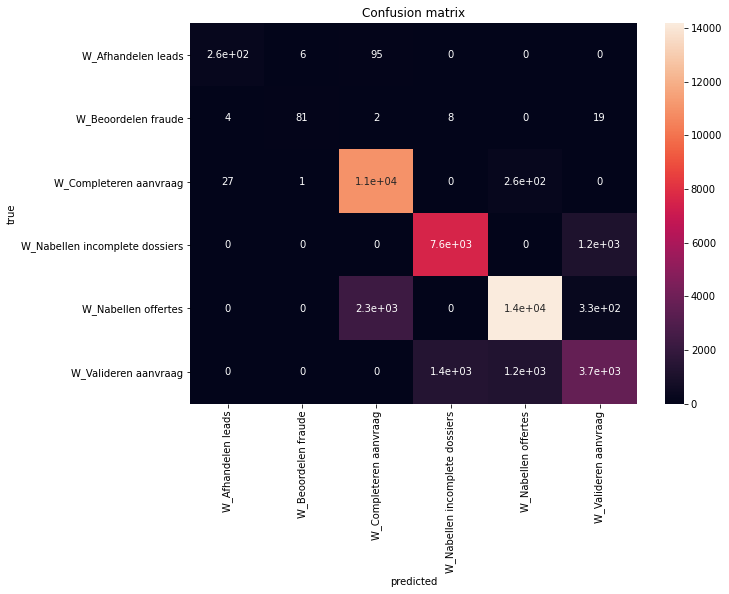

In [80]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, test_labels_hat)
cm_prob = cm / np.nan_to_num(cm, 0).sum(axis=1).reshape(-1, 1)

df_cm = pd.DataFrame(cm, index = activities,
                         columns = activities)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion matrix')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

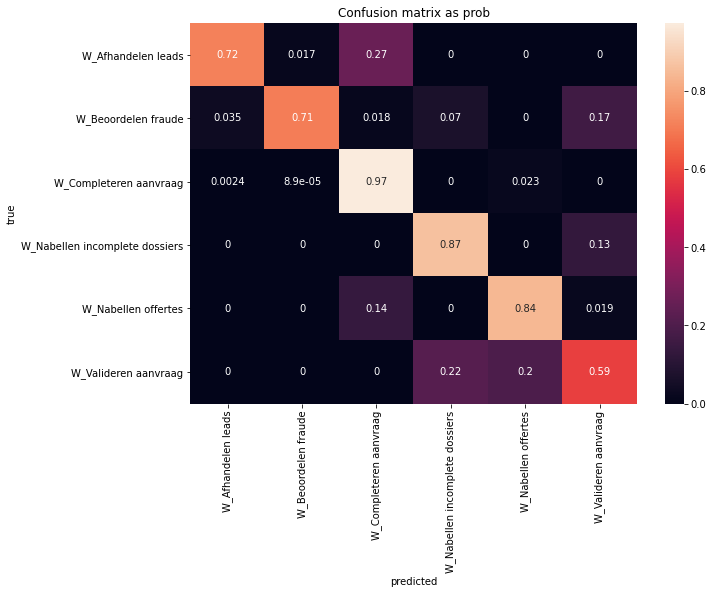

In [81]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, test_labels_hat)
cm_prob = cm / np.nan_to_num(cm, 0).sum(axis=1).reshape(-1, 1)

df_cm = pd.DataFrame(cm_prob, index = activities,
                         columns = activities)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)
plt.title('Confusion matrix as prob')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

## Classification results
Classique approaches povides results, which outperforms result, given in article as baseline, but...

- As been shown in visualization, there are a lot of loops, model that doesnt consern information on all the trail seems to be useless for end time prediction
- Accuracy is what been used for benchmarking in papers. Maybe it is not the best metric? Who knows, nevertheless this is a bench

# Regression

In [82]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error as MAE

In [99]:
%%time
param_grid_rfr = { 
    'rfr__n_estimators': np.linspace(140, 250, num=15, dtype=int),
    'rfr__max_depth' : np.linspace(10, 20, num=10, dtype=int),
}

model_gs_reg = Pipeline([('scaler', PaperScaler(column_feature)),
                         ('rfr', RandomForestRegressor(random_state=42))
                        ])
CV_rfr = GridSearchCV(estimator=model_gs_reg, param_grid=param_grid_rfr, scoring='neg_mean_absolute_error',
                      cv=TimeSeriesSplit(n_splits=5), n_jobs=6, verbose=1)
CV_rfr.fit(train_df_pr_win, train_tes)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  8.4min


KeyboardInterrupt: 

Again better then papers)

In [ ]:
import xgboost as xgb
param = {'max_depth': 17,  # the maximum depth of each tree
         'eta': 0.3,  # the training step for each iteration
         'n_jobs': -1,
         'n_estimators': 7      
        }

xgb_reg = xgb.XGBRegressor(**param)
xgb_reg.fit(train_df_pr_sc_win, train_tes)

train_tes_hat = xgb_reg.predict(train_df_pr_sc_win)
test_tes_hat = xgb_reg.predict(test_df_pr_sc_win)

test_mae_xgb = MAE(test_tes_hat * scaler.scales['te'], test_tes * scaler.scales['te'])
train_mae_xgb = MAE(test_tes_hat * scaler.scales['te'], test_tes * scaler.scales['te'])

print(f'XG boost Regressor')
print(f'Random Forest Classifier\ntest  MAE = {test_mae_xgb / 3600 / 24: .2f}d\ntrain MAE = {train_mae_xgb / 3600 / 24: .2f}d')

XGB is not that cool

# No long activity!